In [56]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import HTML
from IPython.display import display

from skeleton_models import ntu_rgbd, get_kernel_by_group, ntu_ss_1, ntu_ss_2, ntu_ss_3, partial, upsample_columns
from render import animate
import math, copy, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from graph import Graph

import os, glob

In [7]:
sample_data = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P008R002A023.skeleton.npy', allow_pickle=True)[()]

In [8]:
sequence =  sample_data['skel_body0']

In [9]:
sequence.shape

(83, 25, 3)

In [13]:
graph5 = Graph(ntu_ss_2)
cols3 = upsample_columns(ntu_ss_1, ntu_ss_2)
a5 = graph5.getA(cols3)

print(a5.shape)

(2, 5, 1)


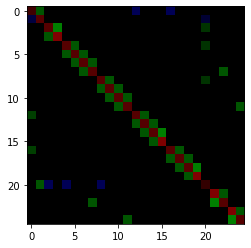

In [15]:
plt.imshow(graph25.A.transpose(1,2,0)[:,:,0:3]) 

In [34]:
ntu_rgbd['ss_selection']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [43]:

def upsample_columns(model_to, model_from):
    assert model_to['num_nodes'] < model_from['num_nodes'] 
    return [ model_from['ss_selection'].index(e) for e in model_to['ss_selection']  ]
   
upsample_columns(ntu_ss_2, ntu_ss_3)


[0, 3, 4, 5, 8]

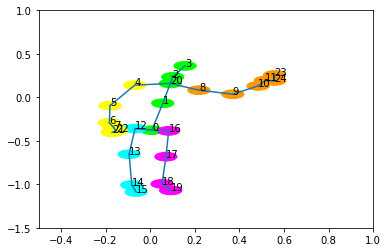

In [5]:
animate(sequence, ntu_rgbd)

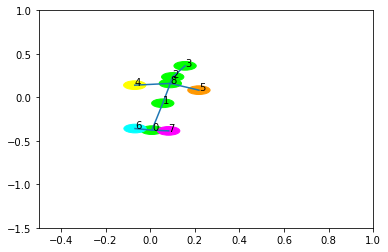

In [6]:
animate(partial(sequence, ntu_ss_3), ntu_ss_3 )

In [6]:
get_kernel_by_group(ntu_rgbd)

/mnt/hielo/projects/pesquisa/mestrado/action-embedding-transformer/skeleton_models.py:62: RuntimeWarning: divide by zero encountered in true_divide
  norm_coeficient = 1/norm_coeficient


array([[[0.5       , 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.5       , 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.33333333,
         0.        , 0.        ],
        [0. 

In [52]:
A = np.array([
[ 1, 1, 1, 1, 1],
[ 1, 1, 0, 0, 0],
[ 1, 0, 1, 0, 0],
[ 1, 0, 0, 1, 0],
[ 1, 0, 0, 0, 1],
    ])
print(A)
print(A.shape)

[[1 1 1 1 1]
 [1 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]]
(5, 5)


In [21]:
X = np.array([
    [0, 0],
    [1, 1],
    [-2, 1],
    [1, -1],
    [-1, -2]
])
print(X)
print(X.shape)

[[ 0  0]
 [ 1  1]
 [-2  1]
 [ 1 -1]
 [-1 -2]]
(5, 2)


In [54]:
Xm = np.stack((X,X,X,X,X,X,X))
# print(Xm)
print(Xm.shape) # N, V, C

(7, 5, 2)


In [55]:
Am = np.stack((A,A))
print(Am)
print(Am.shape) # K, V, V

Am[0] @ Xm[0]

[[[1 1 1 1 1]
  [1 1 0 0 0]
  [1 0 1 0 0]
  [1 0 0 1 0]
  [1 0 0 0 1]]

 [[1 1 1 1 1]
  [1 1 0 0 0]
  [1 0 1 0 0]
  [1 0 0 1 0]
  [1 0 0 0 1]]]
(2, 5, 5)


array([[-1, -1],
       [ 1,  1],
       [-2,  1],
       [ 1, -1],
       [-1, -2]])

In [56]:
np.einsum('nvc,kvw->nwc', Xm, Am)

array([[[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]],

       [[-2, -2],
        [ 2,  2],
        [-4,  2],
        [ 2, -2],
        [-2, -4]]])

In [57]:
class SpatialGCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                      out_channels * kernel_size,
                      kernel_size=(1, 1))
        
    def forward(self, x, A):
        out = self.conv(x) # [N,Cin,T,V] -> [N, K * Cout, T, V]
        out = F.relu(out)
        n, kc, t, v = out.size()
        k = self.kernel_size
        c_in = self.in_channels
        c_out = self.out_channels
        out = out.view(n, k, c_out, t, v) # [N, K * Cout, T, V] -> [N, K, Cout, T, V]
        x = torch.einsum('nkctv,kvw->nctw', (out, A)) # [N, K, Cout, T, V] -> [N, Cout, T, V]
        return x

In [58]:
layer = SpatialGCN(2,2,2)
layer.size

ModuleAttributeError: 'SpatialGCN' object has no attribute 'size'

In [59]:
Xmt = np.stack((Xm,Xm), axis=1)
Xmt.shape

(7, 2, 5, 2)

In [60]:
Xin = torch.from_numpy(Xmt).float()
print(Xin.size())

Xin = Xin.permute(0, 3, 1, 2).contiguous()
print(Xin.size())

Xout = layer(Xin, torch.from_numpy(Am).float())
print(Xout.size())

torch.Size([7, 2, 5, 2])
torch.Size([7, 2, 2, 5])
torch.Size([7, 2, 2, 5])


In [79]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class TemporalSelfAttention(nn.Module):
    def __init__(self, heads, num_nodes, node_channel_in, node_channel_out):
        super().__init__()
        self.h = heads
        self.v = num_nodes
        self.node_in = node_channel_in
        self.node_out = node_channel_out
        self.w_keys = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_queries = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_values = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
    
    def forward(self, x, mask=None):
        n, c, t, v = x.size() # [N, Cin, T, V]
        x = x.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V] 
        x = x.view(n, t, c*v)                  # [N, Cin, T, V] -> [N, T, Cin*V]
        
        keys = torch.stack([ l(x) for l in self.w_keys], dim=1)
        queries = torch.stack([ l(x) for l in self.w_queries], dim=1)
        values = torch.stack([ l(x) for l in self.w_values], dim=1)
         
        att = torch.matmul(queries, keys.permute(0,1,3,2)) / np.sqrt(self.node_out*self.v)
        if mask is not None:
            att = att.masked_fill(mask == 0, -1e9)
        att = torch.softmax(att, dim=-1)
        
        x = torch.matmul(att, values) #  -> [N, H, T, Cout*V]
        x = x.permute(0, 2, 3, 1).contiguous() # [N, H, T, Cout*V] -> [N, T, Cout*V, H]
        x = x.view(n, t, v, self.node_out *  self.h) # [N, T, V * Cout, H] -> [N, T, V, Cout * H]
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V] 
        return x

In [80]:
layer2 = TemporalSelfAttention(3, 5, 2, 2)

In [81]:
mask = subsequent_mask(2)

layer2(Xin, mask).size() 

X torch.Size([7, 2, 10])
Mask torch.Size([7, 3, 2, 2])
tensor([[[-2.3665, -2.3665],
         [-2.3665, -2.3665]],

        [[-2.3665, -2.3665],
         [-2.3665, -2.3665]],

        [[-2.3665, -2.3665],
         [-2.3665, -2.3665]]], grad_fn=<SelectBackward>)
tensor([[[-2.3665e+00, -1.0000e+09],
         [-2.3665e+00, -2.3665e+00]],

        [[-2.3665e+00, -1.0000e+09],
         [-2.3665e+00, -2.3665e+00]],

        [[-2.3665e+00, -1.0000e+09],
         [-2.3665e+00, -2.3665e+00]]], grad_fn=<SelectBackward>)
tensor([[[1.0000, 0.0000],
         [0.5000, 0.5000]],

        [[1.0000, 0.0000],
         [0.5000, 0.5000]],

        [[1.0000, 0.0000],
         [0.5000, 0.5000]]], grad_fn=<SelectBackward>)


torch.Size([7, 6, 2, 5])

In [140]:
n, c, t, v = Xin.size()
Xin2 = Xin.permute(0, 2, 1, 3).contiguous()
Xin2 = Xin2.view(n, t, c*v)
print(Xin2.shape)
w = torch.ones((3,10,v*2))
print('w {}'.format(w.size()))
temp = Xin2.unsqueeze(1)
print(temp.size())
query = torch.matmul(temp, w)
print('Query {}'.format(query.size()))

key = torch.matmul(temp, w)
print('Key {}'.format(key.size()))

value = torch.matmul(temp, w)

print('Value {}'.format(value.size()))
att = torch.matmul(query, key.permute(0,1,3,2)) / np.sqrt(5)
att = torch.softmax(att, dim=1)
print(att.size())

Xout2 = torch.matmul(att,value)
Xout2 = Xout2.permute(0, 2, 3, 1).contiguous()
Xout2 = Xout2.view(7,2,-1)

print(Xout2.size())



torch.Size([7, 2, 10])
w torch.Size([3, 10, 10])
torch.Size([7, 1, 2, 10])
Query torch.Size([7, 3, 2, 10])
Key torch.Size([7, 3, 2, 10])
Value torch.Size([7, 3, 2, 10])
torch.Size([7, 3, 2, 2])
torch.Size([7, 2, 30])


In [83]:
class TemporalInputAttention(nn.Module):
    def __init__(self, heads, num_nodes, node_channel_in, node_channel_out, node_memory_in):
        super().__init__()
        self.h = heads
        self.v = num_nodes
        self.node_in = node_channel_in
        self.memory_in = node_memory_in
        self.node_out = node_channel_out
        self.w_queries = clones(nn.Linear(num_nodes*node_channel_in, num_nodes*node_channel_out), heads)
        self.w_keys = clones(nn.Linear(num_nodes*node_memory_in, num_nodes*node_channel_out), heads)
        self.w_values = clones(nn.Linear(num_nodes*node_memory_in, num_nodes*node_channel_out), heads)
    
    def forward(self, x, m):
        # print('Input x {}'.format(x.size()))
        n, c, t, v = x.size() # [N, Cin, T, V]
        x = x.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V] 
        x = x.view(n, t, c*v)                  # [N, Cin, T, V] -> [N, T, Cin*V]
        # print('Input x2 {}'.format(x.size()))
        
        # print('Input m {}'.format(m.size()))
        mn, mc, mt, mv = m.size() # [N, Cin, T, V]
        m = m.permute(0, 2, 1, 3).contiguous() # [N, Cin, T, V] -> [N, T, Cin, V] 
        m = m.view(mn, mt, mc*mv)                  # [N, Cin, T, V] -> [N, T, Cin*V]
        # print('Input m2 {}'.format(m.size()))
        
        queries = torch.stack([ l(x) for l in self.w_queries], dim=1)
        keys = torch.stack([ l(m) for l in self.w_keys], dim=1)
        values = torch.stack([ l(m) for l in self.w_values], dim=1)
        
        # print('Keys {}'.format(keys.size()))
        # print('Queries {}'.format(queries.size()))
        # print('Values {}'.format(values.size()))
         
        att = torch.matmul(queries, keys.permute(0,1,3,2)) / np.sqrt(self.node_out*self.v)
        att = torch.softmax(att, dim=1)
        # print('Att {}'.format(att.size()))
        
        
        x = torch.matmul(att, values) #  -> [N, H, T, Cout*V]
        x = x.permute(0, 2, 3, 1).contiguous() # [N, H, T, Cout*V] -> [N, T, Cout*V, H]
        x = x.view(n, t, v, self.node_out *  self.h) # [N, T, V * Cout, H] -> [N, T, V, Cout * H]
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V] 
        return x

In [84]:
layer3 = TemporalInputAttention(
    heads = 3, 
    num_nodes = 5, 
    node_channel_in = 2, 
    node_channel_out = 2, 
    node_memory_in = 6)

l3out = layer3(Xin, Min)
print(l3out.size())
layer3.size

NameError: name 'Min' is not defined

In [104]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous() # [N, Cout * H, T, V] -> [N, T, V, Cout * H] ;        
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x = self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        x = x.permute(0, 3, 1, 2).contiguous() # [N, T, V, Cout * H] -> [N, Cout * H, T, V]         
        return x
    
    

class EncoderUnit(nn.Module):
    def __init__(self, heads, node_channel_in, node_channel_mid, node_channel_out, num_nodes=25, kernel_size=5):
        super().__init__()
        
        self.temporal_self_attention = TemporalSelfAttention(
            heads=heads, 
            num_nodes=num_nodes, 
            node_channel_in=node_channel_in, 
            node_channel_out=node_channel_mid)
        
        self.spatial_gcn = SpatialGCN(
            in_channels=heads*node_channel_mid, 
            out_channels=node_channel_out, 
            kernel_size=kernel_size)
        
        self.norm_1 = LayerNorm(node_channel_mid*heads)
        self.norm_2 = LayerNorm(node_channel_out)
       
    def forward(self, x, A):
        x = self.temporal_self_attention(x)
        x = self.norm_1(x)
        x = self.spatial_gcn(x, A)
        x = self.norm_2(x)
        return x

In [105]:
encoder_unit = EncoderUnit(
    heads=3,
    node_channel_in=2,
    node_channel_mid=2,
    node_channel_out=2,
    num_nodes=5,
    kernel_size=2
)
e_unit_out = encoder_unit(Xin, torch.from_numpy(Am).float())
print(e_unit_out.size())

X torch.Size([7, 2, 10])
Mask torch.Size([7, 3, 2, 2])
tensor([[[0.4300, 0.4300],
         [0.4300, 0.4300]],

        [[0.4300, 0.4300],
         [0.4300, 0.4300]],

        [[0.4300, 0.4300],
         [0.4300, 0.4300]]], grad_fn=<SelectBackward>)
tensor([[[0.4300, 0.4300],
         [0.4300, 0.4300]],

        [[0.4300, 0.4300],
         [0.4300, 0.4300]],

        [[0.4300, 0.4300],
         [0.4300, 0.4300]]], grad_fn=<SelectBackward>)
tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<SelectBackward>)
torch.Size([7, 2, 2, 5])


In [107]:

class DecoderUnit(nn.Module):
    def __init__(self, heads, node_channel_in, memory_channel_in, node_channel_mid, node_channel_out, num_nodes=25, kernel_size=5):
        super().__init__()
        
        self.temporal_self_attention = TemporalSelfAttention(
            heads=heads, 
            num_nodes=num_nodes, 
            node_channel_in=node_channel_in, 
            node_channel_out=node_channel_mid[0])
        
        self.temporal_input_attention =  TemporalInputAttention(
            heads=heads, 
            num_nodes = num_nodes, 
            node_channel_in=heads*node_channel_mid[0], 
            node_channel_out=node_channel_mid[1], 
            node_memory_in=memory_channel_in)
        
        self.spatial_gcn = SpatialGCN(
            in_channels=heads*node_channel_mid[1], 
            out_channels=node_channel_out, 
            kernel_size=kernel_size)
        
        self.norm_1 = LayerNorm(node_channel_mid[0]*heads)
        self.norm_2 = LayerNorm(node_channel_mid[1]*heads)
        self.norm_3 = LayerNorm(node_channel_out)
       
    def forward(self, x, m, A):
        x = self.temporal_self_attention(x)
        x = self.norm_1(x)
        x = self.temporal_input_attention(x, m)
        x = self.norm_2(x)
        x = self.spatial_gcn(x, A)
        x = self.norm_3(x)
        return x



In [108]:
decoder_unit = DecoderUnit(
    heads=3,
    node_channel_in=2,
    memory_channel_in=6,
    node_channel_mid=(2,2),
    node_channel_out=2,
    num_nodes=5,
    kernel_size=2
)
d_unit_out = decoder_unit(Xin, Min ,torch.from_numpy(Am).float())
print(d_unit_out.size())

NameError: name 'Min' is not defined

In [114]:
Xin[:,:,0:1,:].size()

torch.Size([7, 2, 1, 5])

In [209]:
class GenerateNodes(nn.Module):
    def __init__(self, total_nodes, node_channel_in, num_seeds, new_nodes, node_channel_out=3):
        super().__init__()
        # self.linear = nn.Linear(total_nodes*node_channel_in + num_seeds*node_channel_out, node_channel_out)
        linear_input_size = total_nodes*node_channel_in + num_seeds*node_channel_out
        self.node_projections = clones(nn.Linear(linear_input_size, node_channel_out), new_nodes)
        
    def forward(self, x, seeds=None):
        n, c, t, v = x.size()
        print(x.size())
        x = x.permute(0, 2, 1, 3).contiguous() # [N, C, T, V] -> [N, T, C, V]
        x = x.view(n, t, c*v)
        
        if seeds != None:
            sn, st, sc, sv = seeds.size()
            seeds = seeds.view(n, t, sc*sv)
            mix = torch.cat( (x,seeds), dim=2 )
        else:
            mix = x
        
        new_nodes = torch.stack([ l(mix) for l in self.node_projections], dim=3)

        return new_nodes


In [210]:
class BestModelEver(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_1, self.encoder_2, self.encoder_3 = clones(EncoderUnit(
            heads=3,
            node_channel_in=2,
            node_channel_mid=2,
            node_channel_out=2,
            num_nodes=5,
            kernel_size=2
        ), 3)
        
        self.decoder_1, self.decoder_2, self.decoder_3 = clones(DecoderUnit(
            heads=3,
            node_channel_in=2,
            memory_channel_in=2,
            node_channel_mid=(2,2),
            node_channel_out=2,
            num_nodes=5,
            kernel_size=2
        ),3 )
        
        
        self.generate_nodes_1 = GenerateNodes(
            total_nodes = 5, 
            node_channel_in = 2, 
            num_seeds = 0, 
            new_nodes = 1
        )
        
        self.generate_nodes_2 = GenerateNodes(
            total_nodes = 5, 
            node_channel_in = 2, 
            num_seeds = 1, 
            new_nodes = 4
        )
        
        self.generate_nodes_3 = GenerateNodes(
            total_nodes = 5, 
            node_channel_in = 2, 
            num_seeds = 5, 
            new_nodes = 4
        )
        


    def forward(self, x_in, x_out, A):
        m = self.encoder_1(x_in, A)
        m = self.encoder_2(m, A)
        m = self.encoder_3(m, A)
        
        d1 = self.decoder_1(x_out, m, A)
        d2 = self.decoder_2(d1, m, A)
        d3 = self.decoder_3(d2, m, A) # [N, Cout, T, V]
        
        partial1 = self.generate_nodes_1(d1)
        
        temp = self.generate_nodes_2(d2, partial1)
        partial2 = torch.cat( (partial1,temp), dim=3 )
        
        temp = self.generate_nodes_3(d3, partial2)
        partial3 = torch.cat( (partial2,temp), dim=3 )
        
        
        return partial1, partial2, partial3

    
    

In [211]:
model = BestModelEver()
d1, d2, d3 = model(Xin, Xin, torch.from_numpy(Am).float())
print(d3.size())

torch.Size([7, 2, 2, 5])
torch.Size([7, 2, 2, 5])
torch.Size([7, 2, 2, 5])
torch.Size([7, 2, 3, 9])


In [244]:
class NTUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform #root_dir
        self.files = glob.glob(root_dir+'*.npy')
        self.crop = CropSequence(20)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_data = np.load(self.files[idx], allow_pickle=True)[()]
        pose_data =  file_data['skel_body0']
        pose_data = self.crop(pose_data)
        if self.transform:
            pose_data = self.transform(pose_data)
            
        return pose_data
    
class CropSequence(object):
    def __init__(self, lenght):
        self.lenght = lenght

    def __call__(self, sample):
        return sample[0:self.lenght]
    
ntu_dataset = NTUDataset(root_dir='../datasets/NTURGB-D/Python/raw_npy/')
ntu_dataset[1].shape

(20, 25, 3)

In [245]:
from torch.utils.data import DataLoader 

loader = DataLoader(ntu_dataset, batch_size=5, shuffle=True)

for data in loader:
    print(data.shape)

torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])
torch.Size([5, 20, 25, 3])


KeyboardInterrupt: 

In [15]:
class Weight(nn.Module):
    def __init__(self,channels,output_nodes):
        super(Weight,self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(2, output_nodes, requires_grad=True))
        self.weight.data.uniform_(-1, 1)

    def forward(self,x):
        # return torch.einsum('ncti,ki->ncti',(x,self.weight))
        print(self.weight.size())
        print(x.size())
        return torch.einsum('kij,ki->kij',(x,self.weight))

In [16]:
w = Weight(2, 5)
A = torch.from_numpy(a5).float()

A.size()

torch.Size([2, 5, 1])

In [34]:
x = torch.tensor([[[[1,1,1,1,1,1,1]]]], dtype=torch.float32)
x = x.permute(0,3,1,2)
x = torch.cat((x,x,x), dim=2)
x.size()

torch.Size([1, 7, 3, 1])

In [35]:
w(A)

torch.Size([2, 5])
torch.Size([2, 5, 1])


tensor([[[-0.4271],
         [ 0.0000],
         [-0.0000],
         [-0.0000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [-0.0000],
         [ 0.0000],
         [ 0.3089]]], grad_fn=<ViewBackward>)

In [53]:
class UpSampling(nn.Module):

    def __init__(self,input_nodes,output_nodes,A):
        super().__init__()
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.A = A
        self.w = Weight(self.A.size(0),output_nodes)

    def forward(self,x):
        assert x.size(3) == self.input_nodes
        assert self.A.size(0) == 2
        assert self.A.size(1) == self.output_nodes
        res = self.w(self.A)
        res = torch.einsum('kij,nctj->ncti',(res,x))
        return res



In [54]:
up = UpSampling(1,5, A)

In [55]:
exit = up(x)
exit.size()

torch.Size([2, 5])
torch.Size([2, 5, 1])


torch.Size([1, 7, 3, 5])

In [57]:
criterion = torch.nn.MSELoss()

In [89]:
a = torch.tensor([[[[1,2],[1,2]],[[1,2],[1,2]]],[[[1,2],[1,2]],[[1,2],[1,2]]]], dtype=torch.float32)
b = torch.tensor([[[[1,1],[1,1]],[[1,1],[1,1]]],[[[1,1],[1,1]],[[1,1],[1,1]]]], dtype=torch.float32)

In [90]:
a.size()

torch.Size([2, 2, 2, 2])

In [88]:
criterion(a,b)

tensor(0.1250)

In [97]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
print('Input {}'.format(input))
target = torch.randn(3, 5)
print('Target {}'.format(target))
for i in range(10):
    output = loss(input, target)
    output.backward()
    print('Loss = {} --- Input at {} = {}'.format(output.item(), i, input))

Input tensor([[-0.0234, -0.0495,  0.1086, -0.4288, -1.0566],
        [-0.4252, -1.0862, -1.3627,  2.4184,  0.6357],
        [ 1.2866, -1.2533,  0.5258, -0.2486,  0.8089]], requires_grad=True)
Target tensor([[-1.7160,  1.1002,  1.0279,  0.0536, -0.2215],
        [ 0.2206,  1.0549,  1.9462, -0.3846,  1.3167],
        [-0.7761, -1.8801, -0.6494,  0.1991, -0.1032]])
Loss = 2.486238718032837 --- Input at 0 = tensor([[-0.0234, -0.0495,  0.1086, -0.4288, -1.0566],
        [-0.4252, -1.0862, -1.3627,  2.4184,  0.6357],
        [ 1.2866, -1.2533,  0.5258, -0.2486,  0.8089]], requires_grad=True)
Loss = 2.486238718032837 --- Input at 1 = tensor([[-0.0234, -0.0495,  0.1086, -0.4288, -1.0566],
        [-0.4252, -1.0862, -1.3627,  2.4184,  0.6357],
        [ 1.2866, -1.2533,  0.5258, -0.2486,  0.8089]], requires_grad=True)
Loss = 2.486238718032837 --- Input at 2 = tensor([[-0.0234, -0.0495,  0.1086, -0.4288, -1.0566],
        [-0.4252, -1.0862, -1.3627,  2.4184,  0.6357],
        [ 1.2866, -1.2533, 